In [1]:
import os, time
import matplotlib.pyplot as plt
import numpy as np
import dgl
import dgl.function as fn
import pickle as pkl
import torch
from sklearn.metrics import recall_score, precision_score, roc_auc_score

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import collections

In [3]:
import seaborn
import matplotlib.ticker as ticker

In [4]:
from xgnn_src.shared_networks import MLP, MLP_PRED
from xgnn_src.node.online_kg2 import AllOnlineKG
import torch.nn.functional as F

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]

In [6]:
from utils import *
from xgnn_src.node.eval import *

In [7]:
Arg = collections.namedtuple("Arg", ["teacher_name", "hidden_sizes", "n_layers", "dropout", "n_hidden", "all_layer_dp", "skip_norm"])

- Nodes of label 0 belong to the base BA graph
- Nodes of label 1, 2, 3 are separately at the middle, bottom, or top of houses

```
python online_kg2.py --dataset BAS --temp 2 --n-epochs 1000 --gpu 0 --teacher-name gcn2 --student-type gcn
    --n-hidden 64 --n-layers 5 --sl-factor 0.1 --lr 0.01 --all-layer-dp
    --skip-norm --add-reverse --teacher-pretrain ./ckpt/gcn/ba_shape_feat_bidir.pt

python online_kg2.py --dataset BAS --temp 2 --n-epochs 1000 --gpu 0 --teacher-name gcn2 --student-type gcn
    --n-hidden 64 --n-layers 5 --sl-factor 0.1 --lr 0.01 --all-layer-dp
    --skip-norm --add-reverse --teacher-pretrain ./ckpt/gcn/ba_shape_feat_bidir.pt
```

In [8]:
# ba_shape1.g, ba_shape.pt
bidir = "bi"
with open('./datasets/ba_shape_%sdir.g'%bidir, 'rb') as f:
    g = pkl.load(f)
    g = dgl.remove_self_loop(g)
    
if not bidir:
    g = dgl.add_self_loop(g)
num_classes = 4
test_labels = g.ndata['label'][g.ndata['test_mask']]
feats = g.ndata['feat'].size()[1]
arg = Arg("gcn2", [64], 5, 0.5, 64, True, True)
base = init_teacher(arg, g, feats, num_classes)
graph_std = init_graph_student("gcn", g, feats, num_classes, 0.5, n_hidden=64,
                                n_layers=5, hidden_sizes=None, all_layer_dp=True, skip_norm=True)
mlp = MLP(feats, [64], num_classes, F.relu, 0.5, batch_norm=True, norm_type='bn')
online_mode = AllOnlineKG(base, graph_std, mlp, graph_student_name="graphsage")
model = torch.load('./ckpt/gcn/ba_shape_feat_%sdir1.pt'%bidir, map_location="cuda:0")
online_mode.load_state_dict(model)

using norm in graph False
GCN2(
  (layers): ModuleList(
    (0): GraphConv(in=3, out=64, normalization=both, activation=None)
    (1): GraphConv(in=64, out=64, normalization=both, activation=None)
    (2): GraphConv(in=64, out=64, normalization=both, activation=None)
    (3): GraphConv(in=64, out=64, normalization=both, activation=None)
    (4): GraphConv(in=64, out=64, normalization=both, activation=None)
    (5): GraphConv(in=64, out=4, normalization=both, activation=None)
  )
  (batch_norms): ModuleList()
  (dropout): Dropout(p=0.5, inplace=False)
)
using norm in graph False
norm type: bn
norm type: bn
norm type: bn


<All keys matched successfully>

In [9]:
b_preds, e_preds = predict(base, graph_std, g)

Base accuracy: 1.0000, Explainer accuracy: 0.9714
Agreement score: 0.9714, KL Score: 0.0151


tensor([3, 2, 2, 3, 2])


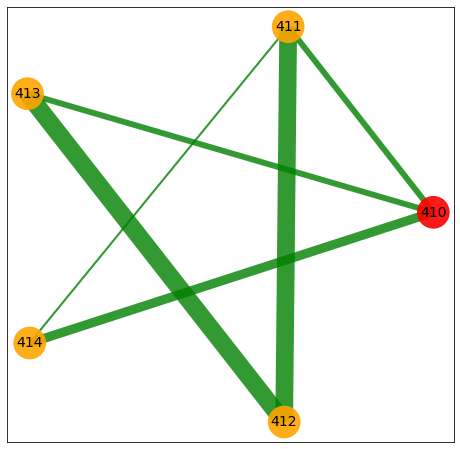

In [12]:
explain_test(g, 410, 6, ax=None, undir=True, scale=10, aggressive=True)

When a node connect to a high degree node => affected by this node when performing PPR

In [10]:
selected_node = list(range(400, 700, 5))
test_graphs = [extract_true_motif(g, i, 399, 5, True) for i in selected_node]

In [20]:
s = time.time()
pred, rec, _ = evaluate_dataset(g, selected_node, test_graphs, 5, 7, ignore_self_loop=True, dumping_factor=0.55)
print(time.time() - s)

60it [00:03, 19.80it/s]

3.0370821952819824


In [21]:
print("F1 %.4f Precision: %.4f Recall %.4f"  % (pred*rec*2/(pred+rec), pred, rec))

F1 1.0000 Precision: 1.0000 Recall 1.0000


## BA Community

```
python online_kg2.py --dataset BAC --temp 2 --n-epochs 1000 --gpu 2 --teacher-name gcn2 
                     --student-type gcn --n-hidden 64 --n-layers 5 --sl-factor 0.3 --lr 0.01
                     --all-layer-dp --skip-norm --add-reverse --teacher-pretrain ./ckpt/gcn/ba_community_feat_bidir.pt
                     
python online_kg2.py --dataset BAC --temp 2 --n-epochs 1000 --gpu 0 --teacher-name gcn2 --student-type gcn --n-hidden 128 --n-layers 4 --sl-factor 0.3 --lr 0.01 --all-layer-dp --skip-norm --add-reverse --teacher-pretrain ./ckpt/gcn/ba_community_feat_bidir1.pt

python online_kg2.py --dataset BAC --temp 2 --n-epochs 1000 --gpu 0 --teacher-name gcn2 --student-type gcn --n-hidden 128 --n-layers 4 --sl-factor 0.1 --lr 0.01 --all-layer-dp --skip-norm --add-reverse --teacher-pretrain ./ckpt/gcn/ba_community_feat_bidir1.pt
```

In [10]:
# best: ba_community_feat_bidir1
bidir = "bi"
with open('./datasets/ba_community_%sdir.g' % bidir, 'rb') as f:
    g1 = pkl.load(f)

# g, num_classes = load_data('BAS')
num_classes = 8
if not bidir:
    g1 = dgl.remove_self_loop(g1)
    g1 = dgl.add_self_loop(g1)
test_labels1 = g1.ndata['label'][g1.ndata['test_mask']]
feats1 = g1.ndata['feat'].size()[1]
# 64 5
arg1 = Arg("gcn2", [64], 4, 0.5, 128, True, True)
base1 = init_teacher(arg1, g1, feats1, num_classes)
graph_std1 = init_graph_student("gcn", g1, feats1, num_classes, 0.5, n_hidden=128,
                                n_layers=4, hidden_sizes=None, all_layer_dp=True, skip_norm=True)
mlp1 = MLP(feats1, [64], num_classes, F.relu, 0.5, batch_norm=True, norm_type='bn')
online_mode1 = AllOnlineKG(base1, graph_std1, mlp1, graph_student_name="gcn")
model1 = torch.load('./ckpt/gcn/ba_community_feat_%sdir2.pt'%bidir, map_location="cuda:0")
online_mode1.load_state_dict(model1)

using norm in graph False
GCN2(
  (layers): ModuleList(
    (0): GraphConv(in=12, out=128, normalization=both, activation=None)
    (1): GraphConv(in=128, out=128, normalization=both, activation=None)
    (2): GraphConv(in=128, out=128, normalization=both, activation=None)
    (3): GraphConv(in=128, out=128, normalization=both, activation=None)
    (4): GraphConv(in=128, out=8, normalization=both, activation=None)
  )
  (batch_norms): ModuleList()
  (dropout): Dropout(p=0.5, inplace=False)
)
using norm in graph False
norm type: bn
norm type: bn
norm type: bn


<All keys matched successfully>

In [38]:
b, e = predict(base1, graph_std1, g1)

Base accuracy: 0.8643, Explainer accuracy: 0.8000
Agreement score: 0.8571, KL Score: 0.0098


In [57]:
def rotate(pos, angle=90):
    if angle != 90 and angle != -90 and angle != 180:
        return pos
    npos = {}
    for k, (x, y) in pos.items():
        if angle == -90:
            npos[k] = np.array([y, -x])
        elif angle == 90:
            npos[k] = np.array([-y, x])
        else:
            npos[k] = np.array([-x, y])
    return npos

def to_undirected(gx, reduce="sum"):
    ngx = nx.Graph()
    ngx.add_edges_from(gx.edges(), w=0)
    for u, v, d in gx.edges(data=True):
        ngx[u][v]['w'] += d['w']
    return ngx

def draw_simple_graph(g, weight=None, undir=True, node_size=1000, margin=0.05,
                      labels=None, node_id=-1, ax=None, self_loop=False, angle=0):
    gx = dgl.to_networkx(g)
    src, dst = g.edges()
    src, dst = src.tolist(), dst.tolist()
    for s, d, w in zip(src, dst, weight):
        gx[s][d][0]['w'] = w
    if undir:
        gx = to_undirected(gx)
    weight = [v for k, v in nx.get_edge_attributes(gx, 'w').items()]
    pos = nx.kamada_kawai_layout(gx)
    pos = rotate(pos, angle)
    nodes = gx.nodes()
    if ax is None:
        ax = plt.subplot()
        ax.margins(margin)
    edge_colors = "green"
    if not weight:
        weight = 1
    if node_id < 0:
        node_colors = 'orange'
    else:
        node_ids = g.ndata["_ID"]
        node_colors = ["red" if node_ids[n] == node_id else "orange" for n in nodes]
    nx.draw_networkx_edges(gx, pos, width=weight,  edge_color=edge_colors, arrows=True,
                           arrowsize=20, alpha=.8, ax=ax)
    if self_loop:
        for node in gx.nodes:
            if (node, node) not in gx.edges:
                continue
            w = gx.get_edge_data(node, node)[0]['w']
            draw_self_loop(point=pos[node], ax=ax, color="green", alpha=0.8, linewidth=w)
    nx.draw_networkx_nodes(gx, pos, nodelist=nodes, node_color=node_colors, node_size=node_size, alpha=.9, ax=ax)
    if labels:
        selected_labels = {v:labels[v] for v in nodes}        
        nx.draw_networkx_labels(gx, pos, selected_labels, font_size=14, font_color="black", ax=ax)

(tensor([0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4]), tensor([1, 3, 2, 4, 0, 2, 0, 1, 0, 4, 3, 1]))


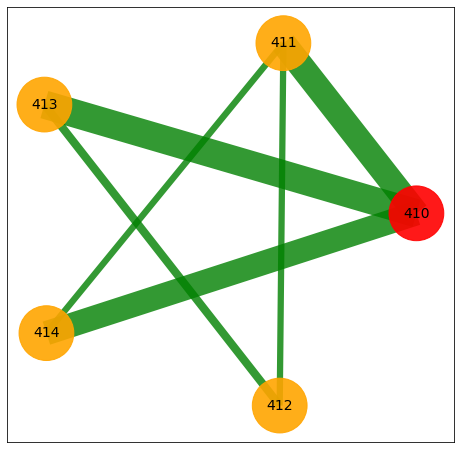

In [61]:
ngtest = explain_test(g1, 410, 6, undir=True, plot=False, scale=20)
old_ids = ngtest.ndata["_ID"]
new_ids = ngtest.nodes()
mapping = {k.item(): v.item() for k, v in zip(old_ids, new_ids)}
weights = scaler(ngtest.edata['prob'])
draw_simple_graph(ngtest, weights * 20, node_id=410,
                 labels={k:v for k, v in zip(ngtest.nodes().tolist(), ngtest.ndata['_ID'].tolist())},
                 margin=0.1, node_size=3000, angle=0)
# plt.savefig('./images/ba_community_510_2.pdf', format="pdf", dpi=300)

In [11]:
selected_node = list(range(400, 700, 5))
test_graphs2 = [extract_true_motif(g1, i, 399, 5, True) for i in selected_node]

In [28]:
s = time.time()
pred1, rec1, _ = evaluate_dataset(g1, selected_node, test_graphs2, 5, 7, dumping_factor=0.55)
print(time.time() - s)

60it [00:03, 18.68it/s]


3.2176694869995117


In [29]:
print("F1: %.4f Precision: %.4f Recall %.4f"  % (pred1*rec1*2/(pred1+rec1), pred1, rec1))

F1: 0.9959 Precision: 0.9917 Recall 1.0000
